# SLU11: Model Validation
---

# TL;DR

The purpose of machine learning is to generalize by uncovering hidden, universal patterns in the training data.

There is no one model that works best for every problem. This has some implications:
* Data alone is not enough, regardless of how much of it we have
* We need to try different models, with different sets of assumptions and parameters
* We need ways to validate and compare the different models to find the one that works best for a particular problem.

# 1 Introduction

One way to understand overfitting is by decomposing the generalization error of a model into bias and variance.

We will be using data about craft beer to try to predict whether a particular beer is an [India Pale Ale (IPA)](https://en.wikipedia.org/wiki/India_pale_ale).

The data was preprocessed in advance, as the original dataset was simplified and manipulated for teaching purposes. There are two features:
* `IBU`, which stands for International Bitterness Units and is a measure of bitterness
* `Color`.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/beer.csv')
data.head(n=3)

,IBU,Color,IsIPA
0,-0.970233,-0.652164,0
1,1.387356,-0.377297,1
2,0.442296,0.183752,0


# 2 Bias-variance trade-off

## 2.1 The critical role of assumptions

In machine learning, unlike other optimization problems, the function we want to optimize is *unknown to us*. All we have are inputs and outputs, and a big black box in the middle.

![black_box](assets/black_box.png)

*Fig 1:*

We need to come up with an hypothesis *h* to approximate the target function *f* that maps input data X to the output variable *y*, given a set of parameters that we will *train* using *X* and *y*:

$$ \hat{y} = h_\Theta(X) $$

An hypothesis is a simplification of the reality that is grounded on a set of assumptions and a few parameters (i.e., the knobs), such as this:

$$ h_\Theta(X) = \theta_0 + \theta_1x_1 + \space ... \space + \theta_ix_i$$

The optimization (or training) bit aims at finding the best parameters that minimize how wrong the model is, subject to our hypothesis:

$$min \space J(\Theta) = - \frac{1}{m} \sum\limits_{i=1}^m \mathcal{L}(h_\Theta(X^{(i)}), y^{(i)})$$

The key point here is: training can only get us so far and, in general, doesn't adjust or correct for bad assumptions.

Let's start by isolating our features *X* and our target variable *y*.

In [2]:
X = data.copy()
y = X.pop('IsIPA')

## 2.2 Defining bias and variance

Since there is no single model that works best for every problem, modelling is grounded on *assumptions* regardless of how much data we have.

bias-variance decomposition is a way of analyzing an algorithm's expected generalization error, with respect to the sum of three terms:

1. Bias
2. Variance
3. Irreducible error.

As we will see, dealing with bias and variance is really about under- (high bias) and over-fitting (high variance).

![dart_throwing_bias_var_tradeoff](assets/dart_throwing_bias_var_tradeoff.png)

*Fig. 1: Graphical illustration of bias and variance using dart-throwing, from [Scott Fortmann-Row's "Understanding the Bias-Variance Trade-off"](http://scott.fortmann-roe.com/docs/BiasVariance.html)*

### 2.2.1 Bias and underfitting

Bias results from oversimplifying assumptions and a lack of model flexibility (or malleability): we are missing parameters that would be in a correct model.

Bias is always learning the same wrong thing, skewing results consistently across different samples and making predictions far-off from the real value:

$$ Bias = \big(E[\hat{y}^{(i)}] - y^{(i)}\big)^2 $$

Fixing bias requires adding complexity to our models, making them more adaptable to the data. 

### 2.2.2 Variance and overfitting

Highly flexible approaches, on the other side, lead the model to overreact to the specifics of the training data, including the noise.

We have more parameters than are justified and end up learning random things, leading results to vary a lot depending on the training sample:

$$ Variance = E\Big[\big(\hat{y}^{(i)} - E[\hat{y}^{(i)}]\big)^2\Big] $$

Fixing variance requires decreasing model complexity, making them more rigid and less eager to learns every single detail from the data.
 
### 2.2.3 The bias variance trade-off explained

In the real world, with imperfect models and limited data, there is an explicit trade-off between bias and variance.

In theory, we reach the right level of complexity when the increase in bias is equivalent to the reduction in variance:

$$ \frac{dBias}{dComplexity} = - \frac{dVariance}{dComplexity} $$

Bias is reduced and variance is increased in relation to model complexity (e.g., additional features, increasing polynomial, using highly flexible models).

![bias_variance_tradeoff_complexity](assets/right_fited_model.png)

*Fig. 2: Graphical example on how bias and variance relate to model complexity*

In practice, there is not an analytical way to find this location. Below are three different models that perform differently in terms of bias and variance.

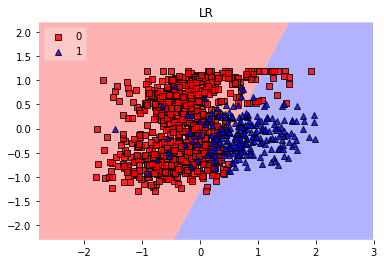

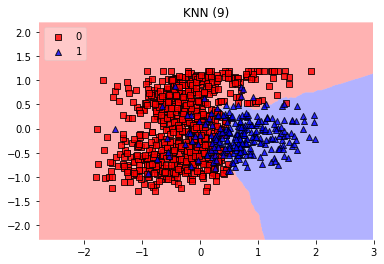

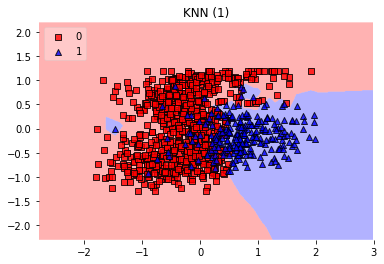

In [3]:
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline


clfs = {'LR': LogisticRegression(),
        'KNN (9)': KNeighborsClassifier(n_neighbors=9),
        'KNN (1)': KNeighborsClassifier(n_neighbors=1)}
   
for key, clf in clfs.items():
    plt.figure()
    plt.title(key)
    plot_decision_regions(X.values, y.values, clf=clf.fit(X, y), legend=2)

---

## 3 Evaluating model performance

### 3.1 In-sample-error (ISE) or training error


The in-sample-error is how well our model performs on the training data, regardless of generalization.

In [4]:
from sklearn.metrics import accuracy_score

def classification_error(clf, X, y):
    y_pred = clf.predict(X)
    error_rate = 1 - accuracy_score(y, y_pred)
    return round(error_rate * 100, 2)
                 
for key, clf in clfs.items():
    clf.fit(X, y)
    training_error = classification_error(clf, X, y)
    print('{} error:\nTrain: {}%'.format(key, training_error))

LR error:
Train: 12.0%
KNN (9) error:
Train: 6.8%
KNN (1) error:
Train: 0.0%


This alone is wrong because we want our models to learn and generalize, rather than memorize (e.g., like a lookup table).

Testing our model's performance on the training data is a common mistake and underestimates the generalization error.

### 3.2 Out-of-sample error (OSE) or testing error

The out-of-sample error measures how well the model performs on previsouly on unseen data and if it's picking up patterns that generalize well.

Ideally, both training and test errors are low and close to one another: the model has anough flexibility to pick up signal and not the noise.

**Underfitting (high bias)**

On the other side, underfitted models tend to perform poorly on both train and test data, having large (and similar) in-sample- and out-of-sample errors.

**Overfitting (high variance)**

Overfitting is detected when a model that performs on training data but not quite so well in the test set: the bigger the gap, the greater the overfitting.

![train_test_error](assets/train_test_error.png)

*Fig 3: How training and test errors behave in regards to model complexity, bias and variance*

#### 3.1.1 Train-test split (aka holdout method)

The best possible solution is to leave a random subset of the data aside from the beginning to test our final model at the end.

![test_set](assets/test_set.png)

*Fig 4: Test set illustrated, you holdout a significant chunk of the data for testing your model in the end*

We must keep the test data aside for the entire modelling process, otherwise knowledge about the test set will *leak* into the model and ruin the experiment.

![train_test_set](assets/train_test_split.png)

*Fig 5: Workflow with test and training sets*

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print("Number of observations:\nTrain: {} | Test: {}".format(X_train.shape[0], X_test.shape[0]))

Number of observations:
Train: 600 | Test: 400


In [6]:
def compute_metrics(X_train, y_train, X_test, y_test, clf):
    training_error = classification_error(clf, X_train, y_train)
    test_error = classification_error(clf, X_test, y_test)
    return training_error, test_error

for key, clf in clfs.items():
    clf.fit(X_train, y_train)
    training_error, test_error = compute_metrics(X_train, y_train, X_test, y_test, clf)
    print('{} error:\nTrain: {:5}% | Test: {}%'.format(key, training_error, test_error))

LR error:
Train: 12.33% | Test: 11.0%
KNN (9) error:
Train:  7.83% | Test: 6.5%
KNN (1) error:
Train:   0.0% | Test: 11.5%


**Pro tip:** after evaluation, relearn your final model on the whole data.

But if you need to keep the test data aside until we have a final model, how can we diagnose under- and overfitting during model selection? 

#### 3.1.2 Validation set

Given we have enough data, we can create a *validation dataset*.

![validation_set](assets/validation_set.png)

*Fig. 6: Validation set as compared with the holdout approach*

![validation_split](assets/validation_split.png)

*Fig. 7: Workflow with test, validation and training sets*

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)
del X_temp, y_temp

print("Number of observations:\nTrain: {} | Test: {} | Validation: {}".format(X_train.shape[0], X_test.shape[0], X_val.shape[0]))

Number of observations:
Train: 600 | Test: 200 | Validation: 200


In [8]:
def compute_validation_metrics(X_train, y_train, X_test, y_test, X_validation, y_validation, clf):
    training_error, test_error = compute_metrics(X_train, y_train, X_test, y_test, clf)
    validation_error = classification_error(clf, X_validation, y_validation)
    return training_error, test_error, validation_error

for key, clf in clfs.items():
    clf.fit(X_train, y_train)
    training_error, test_error, validation_error = compute_validation_metrics(X_train, y_train, X_test, y_test, X_val, y_val, clf)
    print('---\n{} error:\nTrain: {:5}% | Test: {:4}% | Validation: {:4}%'.format(key, training_error, test_error, validation_error))

---
LR error:
Train: 11.83% | Test: 11.5% | Validation: 11.5%
---
KNN (9) error:
Train:   7.0% | Test:  9.5% | Validation:  5.5%
---
KNN (1) error:
Train:   0.0% | Test: 14.5% | Validation: 10.5%


**Drawbacks of the validation set**

Test error results can be subject to great variability, especially for smaller datasets, depending on how we split the data (i.e., which observations go where).

Also, and quite obviously, holding out *more* data reduces the amount available for training, possibly leading us to overestimate the test error.

Resampling deals with these two limitations directly and are more suited to small to medium size datasets.

#### 3.1.3 Resampling methods

These techniques refit a model to samples formed from the training set to estimate the test error.

**K-fold cross-validation**

In *k*-fold cross validation the original sample is randomly partitioned into *k* equal sized parts, or subsamples.

Then, each time, we leave out part *k*, fit the model to the other *k*-1 subsets combined in a single dataset, and then test the model against the left out *k*th part.

This is done for each *k* = 1, 2, ..., *K*, and then the results are combined, using, for example, the mean error.

![cross_validation](assets/cross_validation.png)

*Fig 8: Creating multiple (K=5) train and test set pairs using cross-validation*

This way, we use every observation to both train and test out model: each fold is used once as validation, while the *k*-1 remaining folds form the training set.

Nonetheless, since each training set contains part of the data, the estimated test error can, still, be biased upward (unless *K* = *n*, but this is not desirable, due to high variance).

Typically, *K* = 5 or 10 provides a good compromise.

In [9]:
from sklearn.model_selection import cross_val_score


for key, clf in clfs.items():
    scores = cross_val_score(clf, X, y, cv=10, scoring=classification_error)
    mean_error = round(np.mean(scores), 2)
    var_error = round(np.var(scores), 2)
    print('---\n{} validation error:\nMean: {:5}% | Variance: {:4}'.format(key, mean_error, var_error))

---
LR validation error:
Mean: 11.98% | Variance: 5.82
---
KNN (9) validation error:
Mean:  7.99% | Variance: 9.57
---
KNN (1) validation error:
Mean: 11.88% | Variance: 11.87


**Bootstrapping**

Bootstraping consists of repeatedly sampling observations from the original data, with replacement, to create multiple bootstrap datasets with the same size *n* as the original dataset.

We will use `np.random.choice()` to generate a random sample, with replacement, of * n* rows.

In [10]:
np.random.choice([1, 2, 3, 4, 5], size=5, replace=True)

array([3, 2, 4, 1, 1])

In [11]:
def create_bootstrap_dataset(X, y):
    n = X.shape[0]
    train_obs = np.random.choice(X.index, size=n, replace=True)
    return X.loc[train_obs], y.loc[train_obs]

Now, we will to generate many bootstrap datasets.

In [12]:
def bootstrap(X, y, n_datasets=1000):
    datasets = {}
    for i in range(0, n_datasets):
        X_z, y_z = create_bootstrap_dataset(X, y)
        dataset = {'X': X_z, 'y': y_z}
        z = len(datasets)
        datasets.update({z: dataset})
    return datasets
        
datasets = bootstrap(X, y)

We can train our model using our bootstrap datasets, and test it against the original dataset.

In [13]:
results = {}
for name, clf in clfs.items():
    results[name] = {}
    for key, dataset in datasets.items():
        X_train, y_train = dataset['X'], dataset['y']
        X_test, y_test = X, y
        clf.fit(X_train, y_train)
        training_error, test_error = compute_metrics(X_train, y_train, X_test, y_test, clf)
        results[name].update({key: test_error})

Finally, we generate a distribution of the generalization error.

---
LR validation error:
Mean: 11.82% | Variance: 0.05
---
KNN (9) validation error:
Mean:  7.54% | Variance: 0.21
---
KNN (1) validation error:
Mean:  4.38% | Variance: 0.25


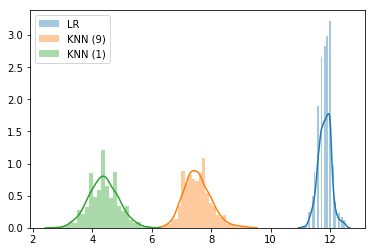

In [14]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

for key, result in results.items():
    prediction_errors = list(result.values())
    mean_error = round(np.mean(prediction_errors), 2)
    var_error = round(np.var(prediction_errors), 2)
    sns.distplot(prediction_errors, label=key)
    print('---\n{} validation error:\nMean: {:5}% | Variance: {:4}'.format(key, mean_error, var_error))

plt.legend(loc=0)
plt.show()